# Simulations <br>
The coordinate systems is the same as the one in the lab:
- $\bf{\hat{x}}$: beam propagation direction 
- $\bf{\hat{y}}$: horizontal direction 
- $\bf{\hat{z}}$: vertical direction (parallel to g)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
# def install_and_import(package):
# 	import subprocess
# 	import sys
# 	try:
# 		__import__(package)
# 	except ImportError:
# 		try:
# 			subprocess.check_call([sys.executable, "-m", "pip", "install", package])
# 		except:
# 			subprocess.check_call([sys.executable, "-m", "pip", "install", f"py{package}"])
# 		__import__(package)
		
# install_and_import("tqdm")
# install_and_import("h5py")
# install_and_import("joblib")
# install_and_import("seaborn")
# install_and_import("sympy")
# install_and_import("numba")
# install_and_import("ipywidgets")
from tqdm.notebook import tqdm
import datetime
import os
import h5py
import joblib
import sys
sys.path.insert(0, '//ARQUS-NAS/ArQuS Shared/Simulations/MOT capture simulation/Simulations_11_2024/')

import Simulations_Libraries.general_library as genlib
import Simulations_Libraries.Yb_library as yblib
import Simulations_Libraries.trajectory_library as trajlib

plt.rcParams.update({'font.size': 18})

4


In [3]:
# Universal Constants

# Loading constants
c = const.physical_constants["speed of light in vacuum"][0]
h = const.physical_constants["Planck constant"] [0]
hbar = h/(2*np.pi)
kB = const.physical_constants["Boltzmann constant"][0]
muB = 1.399*10 ** 6;                # Bohr's magneton [Hz/G]

nm = 10**-9
MHz = 10**6
kHz = 10**3

# Initialise ytterbium atoms 
Yb_171 = yblib.Yb(171,170.936323,1/2)
Yb_173 = yblib.Yb(173,172.938208,5/2)
Yb_174 = yblib.Yb(173,173.938859,0)
Isotope = Yb_174
m = Isotope.m

# State(Isotope, name, S, L, J)
_1S0 = yblib.State(Isotope,"1S0",0,0,0)
_1P1 = yblib.State(Isotope,"1P1",0,0,1)
_3P1 = yblib.State(Isotope,"3P1",1,1,1)
gJ_1S0_1P1 = 1.035
gJ_1S0_3P1 = 1.493

## GS (1S0) Transitions (g.s., e.s., lambda (m), 2pi Gamma (s^-1), *I_sat (mW/cm^2)):
GS_Transitions = []
GS_Transitions.append(yblib.Transition(_1S0,_1P1,398.911*nm,183.02*MHz,59.97)) # values of lambda and gamma from Riegger Table B.1
GS_Transitions.append(yblib.Transition(_1S0,_3P1,555.802*nm,1.15*MHz,0.139))

# Initialize atoms

In [4]:
N = 500
Atoms0 = trajlib.CreateAtoms(N, m, Show = False)

# 1 Run to test:

## Create the beams configuration

# Scan of HOR MOT power

## Create objects that do not change during the scan

GREEN MOT:
Detuning: -4.8 gamma, P: (5.200000000000001,5.200000000000001,0.06872233929727672) mW, diameter: (12.0,10.0) mm
H saturation: 65.68299238713142
V saturation: 1.25
Magnetic fiedl gradient: 12.02 G/cm
Capture range: 2.633 mm
Capture velocity: 5.0 m/s
0% down beam


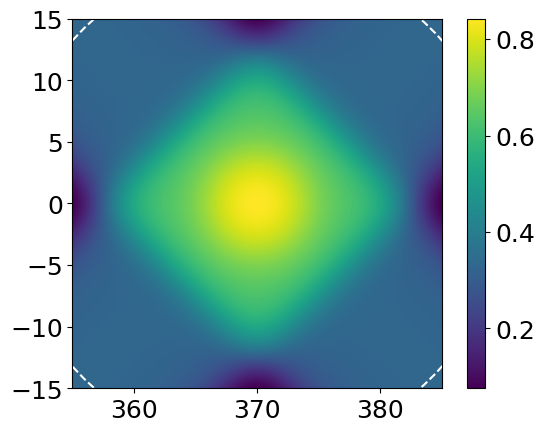

In [ ]:
show_beams = True
show_B = False

Total_Length = 37*10**-2 # Distance between AoSense output and center of the glass cell
x_cell = Total_Length-20*10**-3-10*10**-3
Ngrid = 200
# B field:
I_coils = 7.7*1.2/8*12 # G/cm

# Green MOT
detuning_G_HOR = -5.5*MHz
G_freq_HOR = c/(GS_Transitions[1].Lambda) + detuning_G_HOR
G_lambd_HOR = c/G_freq_HOR
k_mod_G_HOR = 2*np.pi/G_lambd_HOR

G_freq_VER = c/(GS_Transitions[1].Lambda) -3.8*MHz
G_lambd_VER = c/G_freq_VER
k_mod_G_VER = 2*np.pi/G_lambd_VER

MOT_HorSize = 12*10**-3 
MOT_VerSize = 10*10**-3 
s_VER = 1.25 # saturation of VER beam 
P1_G = 5.2*10**-3 
P2_G = 5.2*10**-3 
Is = 1.4    #W/m^2
P3_G = s_VER*Is/2*(np.pi*(MOT_VerSize/2)**2)
percent = 0
print('GREEN MOT:')
print('Detuning: {} gamma, P: ({},{},{}) mW, diameter: ({},{}) mm'.format(np.round(detuning_G_HOR/(GS_Transitions[1].Gamma),1),P1_G*10**3,P1_G*10**3,P3_G*10**3,MOT_HorSize*10**3,MOT_VerSize*10**3,MOT_VerSize*10**3))
print(f'H saturation: {2*P1_G/(np.pi*(MOT_HorSize/2)**2)/Is}')
print(f'V saturation: {s_VER}')

# MOT capture range:
x, y, z = trajlib.Space_grid(Ngrid = 200, cell_center = 370e-3, y_lim = 15, z_lim = 8, start = 355e-3)
x_grid, y_grid, z_grid = np.meshgrid(x,y,z,indexing = 'ij')
B = lambda x_grid, y_grid, z_grid : trajlib.AntiHelmhotz(trajlib.CoordinateChange((x_grid, y_grid, z_grid),3*np.pi/4,Total_Length),I_coils,x,y,z,PlotB=False)
# B = trajlib.AntiHelmhotz(trajlib.CoordinateChange((x_grid, y_grid, z_grid),3*np.pi/4,Total_Length),I_coils,x,y,z,PlotB=False)
grad_z = 2*B(genlib.Find_Target(Total_Length,x),genlib.Find_Target(0,y),genlib.Find_Target(5e-3,z))
print(f'Magnetic fiedl gradient: {np.round(grad_z,2)} G/cm')
## Plot B
if show_B:
    figure, axes = plt.subplots(1,3,figsize = (25,5))
    axes[0].plot(x*10**3, B(list(range(len(x_grid))),genlib.Find_Target(0,y),genlib.Find_Target(0,z)),color='tab:orange')
    axes[0].set_xlabel('x (mm)')
    axes[0].set_xlim(365,375)
    axes[0].set_ylim(0,2.25)

    axes[0].set_ylabel('B (G)')
    axes[1].plot(y*10**3, B(genlib.Find_Target(Total_Length,x),list(range(len(y_grid))),genlib.Find_Target(0,z)),color='tab:orange')
    axes[1].set_xlabel('y (mm)')
    axes[1].set_ylabel('B (G)')
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(0,2.25)
    axes[2].plot(z*10**3, B(genlib.Find_Target(Total_Length,x),genlib.Find_Target(0,y),list(range(len(z_grid)))),color='tab:orange')
    axes[2].set_xlabel('z (mm)')
    axes[2].set_ylabel('B (G)')
    axes[2].set_xlim(-5,5)
    axes[2].set_ylim(0,5)
    plt.show()


rc = -hbar*2*np.pi*detuning_G_HOR/(gJ_1S0_3P1*muB*hbar*2*np.pi*10*100)
vc = np.sqrt(2*rc*hbar*2*np.pi/GS_Transitions[1].Lambda*GS_Transitions[1].Gamma/m)
print('Capture range: {} mm'.format(np.round(rc*10**3,3)))
print('Capture velocity: {} m/s'.format(np.round(vc,2)))

x1, y1, z1 = trajlib.CoordinateChange((x_grid, y_grid, z_grid),np.pi/4,Total_Length)
G_MOT_Beam1 = trajlib.GaussianBeam((x1,y1,z1),556*10**-9,MOT_HorSize/2,MOT_HorSize/2,P1_G)

x1, y1, z1 = trajlib.CoordinateChange((x_grid, y_grid, z_grid),-np.pi/4,Total_Length)
G_MOT_Beam2 = trajlib.GaussianBeam((x1,y1,z1),556*10**-9,MOT_HorSize/2,MOT_HorSize/2,P2_G)

G_MOT_Beam3 = trajlib.GaussianBeam(trajlib.CoordinateChange((z_grid,x_grid-Total_Length, y_grid),0,0),556*10**-9,MOT_VerSize/2,MOT_VerSize/2,P3_G)
G_MOT = G_MOT_Beam1+G_MOT_Beam2+G_MOT_Beam3 
E01_G = genlib.I2E_0(G_MOT_Beam1)
E02_G = genlib.I2E_0(G_MOT_Beam2)
E03_G = genlib.I2E_0(G_MOT_Beam3)
E03_G_down = genlib.I2E_0(G_MOT_Beam3*percent)
print(f'{percent*100}% down beam' )


s1 = G_MOT_Beam1/GS_Transitions[1].Is/(1+G_MOT_Beam1/GS_Transitions[1].Is)
s2 = G_MOT_Beam2/GS_Transitions[1].Is/(1+G_MOT_Beam2/GS_Transitions[1].Is)
s3 = G_MOT_Beam3/GS_Transitions[1].Is/(1+G_MOT_Beam3/GS_Transitions[1].Is)
s_all_MOT = s1+s2+s3
s_MOT_topview = np.transpose(s_all_MOT[:,:,genlib.Find_Target(0,z)])
s_MOT_sideview = np.transpose(s_all_MOT[:,genlib.Find_Target(0,y),:])
if show_beams: 
    plt.plot(Total_Length*10**3+20*np.cos(np.linspace(0,2*np.pi,100)),20*np.sin(np.linspace(0,2*np.pi,100)),color='white',linestyle = '--')
    plt.imshow(s_MOT_topview/3,cmap='viridis', extent = (np.amin(x)*10**3,np.amax(x)*10**3,np.amin(y)*10**3,np.amax(y)*10**3)) 
    plt.colorbar()
    plt.show()

## Define scan

In [7]:
# Green MOT

HOR_powers = np.flip(np.array([2.5,5,10,20,30])*1e-3)
print(HOR_powers)
SaveOnFile = True
Show = False
Considered = 20
Atoms = Atoms0[0:Considered]
Deterministic = True
deterministic_v = 0
deterministic_x = 370

t_end = 200*10**-3  # simulation duration
tau_excited = 1/GS_Transitions[1].Gamma # lifetime of the excited state
dt_no_scatter = tau_excited # simulation dt when the atom has not scattered a photon  
N_steps = int(t_end/(dt_no_scatter)) # Number of steps of the simulation
print(f'Number of simulation steps: {int(N_steps*1e-3)}k')

[0.03   0.02   0.01   0.005  0.0025]
Number of simulation steps: 230k


## Run


In [8]:
for pow in HOR_powers:
    print(f'HOR MOT power = {pow*1e3} mW')
    P1_G = pow
    P2_G = pow
    G_MOT_Beam1 = trajlib.GaussianBeam((x1,y1,z1),556*10**-9,MOT_HorSize/2,MOT_HorSize/2,P1_G)
    G_MOT_Beam2 = trajlib.GaussianBeam((x1,y1,z1),556*10**-9,MOT_HorSize/2,MOT_HorSize/2,P2_G)
    E01_G = genlib.I2E_0(G_MOT_Beam1)
    E02_G = genlib.I2E_0(G_MOT_Beam2)
    filename = f'/5BMOT_holding_HOR_power_{np.round(pow*1e3,1)}mW_VER_power{np.round(s_VER,1)}I_sat_{t_end*1e3}ms.h5'
    k1_G = np.array([k_mod_G_HOR*np.cos(3*np.pi/4),+k_mod_G_HOR*np.sin(3*np.pi/4),0]) # (x,y,z)
    k2_G = np.array([k_mod_G_HOR*np.cos(3*np.pi/4),-k_mod_G_HOR*np.sin(3*np.pi/4),0])
    k3_G = np.array([0,0,k_mod_G_VER])
    if SaveOnFile:
        path = f'Results/5B MOT simulations/{datetime.date.today()}/HOR_power_scan'
        if not os.path.exists(path):
            os.makedirs(path)
        with h5py.File(path+filename,'w') as save_file:
            params = save_file.create_group("Simulation parameters")
            params['Magnetic field gradient'] = np.round(grad_z,2)
            params['Magnetic field gradient'].attrs['units'] = 'G/cm'
            params['VER beam diameter'] = MOT_VerSize*1e3
            params['VER beam diameter'].attrs['units'] = 'mm'
            params['HOR beam diameter'] = MOT_HorSize*1e3
            params['HOR beam diameter'].attrs['units'] = 'mm'
            # params['VER beam detuning'] = detuning_G_VER/MHz
            # params['VER beam detuning'].attrs['units'] = 'MHz'
            params['HOR beam detuning'] = detuning_G_HOR/MHz
            params['HOR beam detuning'].attrs['units'] = 'MHz'
            params['VER beam power'] = P3_G*1e3
            params['VER beam power'].attrs['units'] = 'mW'
            params['HOR beam power'] = pow*1e3
            params['HOR beam power'].attrs['units'] = 'mW'
            params['VER beam saturation'] = s_VER
            params['VER beam power'].attrs['units'] = 'I_sat'
            params['Determinsitc'] = Deterministic
            if Deterministic:
                params['Initial position'] = [deterministic_x,0,0]
                params['Initial position'].attrs['units'] = 'mm'
                params['Initial velocity'] = [deterministic_v,0,0]
                params['Initial position'].attrs['units'] = 'mm'
            params['Simulation time'] = t_end*1e3
            params['Simulation time'].attrs['units'] = 'ms'
            params['N trajectories'] = Considered
            save_file.close()
    # Recover atoms from backup:
    if Deterministic == True:
        for i in range(Considered):
            Atoms[i].X = deterministic_x*10**-3 
            Atoms[i].Y = 0
            Atoms[i].Z = 0
            Atoms[i].vx = deterministic_v
            Atoms[i].vy = 0
            Atoms[i].vz = 0

    # Define arrays for simulation:
    final_pos_all = []
    final_v_all = []
    avg_z_all = []
    std_z_all = []
    avg_vz_all = []
    z_excursion_all = []
    P_sc_all = []
    Blue_photons_all = []
    Green_photons_all = []
    t_all = []
    Captured = np.zeros(Considered)
    last =[]
    dts_all = []
    which_all = []

    for n in tqdm(range(Considered)):
        P_sc = 0
        x_traj = []
        v_traj = []
        P_sc_arr = []
        Blue_photons = 0
        Green_photons = 0
        t = 0    
        A: trajlib.Atom = Atoms[n]
        which = []
        dts = []
        for step in range(N_steps):
            P_sc_MOT = np.zeros(5)    
            MOT_scatter = False
            MOT_try = False
            NoScatter = False
            Dv = np.zeros(3)
            v_traj.append([A.vx,A.vy,A.vz])
            x_traj.append([A.X,A.Y,A.Z])
            pos_x = genlib.Find_Target(A.X,x)
            pos_y = genlib.Find_Target(A.Y,y)
            pos_z = genlib.Find_Target(A.Z,z)

            # Find the magnetic shift: consider that atoms scattering from opposite beams will see opposite magnetic shifts
            B_act = B[pos_x,pos_y,pos_z]
        
            # Decide from which beam the atom tries to absorb a photon
            newCoordinates = np.asarray(trajlib.CoordinateChange((x[pos_x],y[pos_y],z[pos_z]),3*np.pi/4,Total_Length))
            # First: compute P_sc for all beams

            P_sc_MOT[0] = tau_excited*trajlib.ScatteringRate_2Level_Doppler3D_Bfield(GS_Transitions[1],G_lambd_HOR,E01_G[pos_x,pos_y,pos_z],k1_G,[A.vx,A.vy,A.vz],np.sign(newCoordinates[0])*gJ_1S0_3P1*muB*B_act)
            P_sc_MOT[1] = tau_excited*trajlib.ScatteringRate_2Level_Doppler3D_Bfield(GS_Transitions[1],G_lambd_HOR,E01_G[pos_x,pos_y,pos_z],-k1_G,[A.vx,A.vy,A.vz],-np.sign(newCoordinates[0])*gJ_1S0_3P1*muB*B_act)
            
            P_sc_MOT[2] = tau_excited*trajlib.ScatteringRate_2Level_Doppler3D_Bfield(GS_Transitions[1],G_lambd_HOR,E02_G[pos_x,pos_y,pos_z],k2_G,[A.vx,A.vy,A.vz],np.sign(newCoordinates[1])*gJ_1S0_3P1*muB*B_act)
            P_sc_MOT[3] = tau_excited*trajlib.ScatteringRate_2Level_Doppler3D_Bfield(GS_Transitions[1],G_lambd_HOR,E02_G[pos_x,pos_y,pos_z],-k2_G,[A.vx,A.vy,A.vz],-np.sign(newCoordinates[1])*gJ_1S0_3P1*muB*B_act)
            
            P_sc_MOT[4] = tau_excited*trajlib.ScatteringRate_2Level_Doppler3D_Bfield(GS_Transitions[1],G_lambd_VER,E03_G[pos_x,pos_y,pos_z],k3_G,[A.vx,A.vy,A.vz],np.sign(newCoordinates[2])*gJ_1S0_3P1*muB*B_act)
            #----------------------------------------------------------------------------
            # Decide from which beam you want to scatter from:
            # Roll a loaded die: divide the (0,1) interval into unequal intervals
            Psc_combined = P_sc_MOT
            P_sc_arr.append(P_sc_MOT)
            Weight_tot = np.sum(Psc_combined)/np.mean(Psc_combined)
            beam_guess = np.random.uniform(0,1)
            weights = Psc_combined/np.mean(Psc_combined)/Weight_tot   
            if np.max(Psc_combined) < 10**-3:
                NoScatter = True
                which.append(0)
            else:
                if beam_guess < weights[0]:
                    MOTBeam = 1
                    k_MOT = k1_G
                    MOT_try = True
                    which_temp = 1
                elif beam_guess > weights[0] and beam_guess < np.sum(weights[:2]):
                    MOTBeam = 2
                    k_MOT = -k1_G
                    MOT_try = True
                elif beam_guess > np.sum(weights[:2]) and beam_guess < np.sum(weights[:3]):
                    MOTBeam = 3
                    k_MOT = k2_G
                    MOT_try = True
                elif beam_guess > np.sum(weights[:3]) and beam_guess < np.sum(weights[:4]):
                    MOTBeam = 4
                    k_MOT = -k2_G
                    MOT_try = True
                elif beam_guess > np.sum(weights[:4]):
                    MOTBeam = 5
                    k_MOT = k3_G
                    MOT_try = True 
                else:
                    print('Houston')
                    print(beam_guess)
                    print(weights)
                    break
            if MOT_try == True: # Try to scatter from the MOT beams
                if np.random.uniform(0,1) < P_sc_MOT[MOTBeam-1]:
                    Dv += hbar*k_MOT/m+trajlib.SpontaneousEmission(GS_Transitions[1].Lambda,m)
                    Green_photons += 1
                    MOT_scatter = True # the atom has scattered from the crossed beams
                    which.append(MOTBeam)
                else:
                    which.append(0)

            #-------------------------------------------------------------------------------
            # The atom has attempted scattering from both crossed beams and MOT: it goes forward
            if MOT_scatter == True: 
                # if the atom has scattered from the MOT, it is excited to the excited state and it spends there a time dt before being able to scatter again 
                Dt = tau_excited
            else:
                Dt = dt_no_scatter
            trajlib.OneStep(A,Dv,Dt)    
            t += Dt
            dts.append(Dt)    
            #-------------------------------------------------------------------------------
            # Captured condition
            # if np.abs(A.vz) < vc and np.abs(A.vx) < vc and np.abs(A.vy)<vc:
                # If all 3 velocities are ok to be captured
            # Break conditions:  
            if  t >= t_end:
                if Show: print(f'Atom {n+1} time finished at step {step}')
                last.append(step)
                break
            elif(np.sqrt(A.Y**2+(A.X-Total_Length)**2)>15*10**-3 and A.X>Total_Length):
                if Show: print(f'Atom {n+1} out horizontally at step {step}')
                last.append(step)
                break
            elif np.abs(A.Z) > 10*10**-3:
                if Show: print(f'Atom {n+1} out vertically at step {step}')
                last.append(step)
                break
            elif A.X < 350e-3 and A.vx < 0:
                if Show: print(f'Atom {n+1} going back at step {step}')
                last.append(step)
                break


        if np.sqrt(A.Y**2+(A.X-Total_Length)**2) <MOT_VerSize/2 and np.abs(A.Z) < MOT_HorSize/2:
            T = m*(A.vx**2+A.vy**2+A.vz**2)/(3*kB)
            Captured[n] = 1
            if Show: print(f'Atom {n+1} captured')
        
        if Show == True:
            print('-------------------------------------------------------------------------------------------------')
            print('-------------------------------------------------------------------------------------------------')
            print(f'Atom {n+1}')
            print('Initial: (vx, vy, vz): ({}, {}, {}) m/s'.format(np.round(np.asarray(v_traj)[0,0],2),np.round(np.asarray(v_traj)[0,1],2),np.round(np.asarray(v_traj)[0,2],2)))       
            print('Initial: (x, y, z): ({}, {}, {}) mm'.format(np.round(np.asarray(x_traj)[0,0]*10**3,2),np.round(np.asarray(x_traj)[0,1]*10**3,2),np.round(np.asarray(x_traj)[0,2]*10**3,2)))          
            print(f'Scattered photons: {Blue_photons} 399 nm, {Green_photons} 556 nm in {t*10**3} ms ')
            print('Final: (vx, vy, vz): ({}, {}, {}) m/s'.format(np.round(A.vx,2),np.round(A.vy,2),np.round(A.vz,2)))       
            print('Final: (x, y, z): ({}, {}, {}) mm'.format(np.round(A.X*10**3,2),np.round(A.Y*10**3,2),np.round((A.Z)*10**3,2)))
            figure, axes = plt.subplots(2,2,figsize=(18,12))
            axes[0][0].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(P_sc_arr)[:,0],label='MOT 1',color='navy')
            axes[0][0].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(P_sc_arr)[:,1],label='MOT $1_r$',color='royalblue')
            axes[0][0].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(P_sc_arr)[:,2],label='MOT 2',color='lawngreen')
            axes[0][0].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(P_sc_arr)[:,3],label='MOT$2_r$',color='lawngreen',linestyle='-.')
            axes[0][0].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(P_sc_arr)[:,4],label='MOT $\\uparrow$',color='orangered',linestyle='-.')
            axes[0][0].set_xlabel('t (ms)')
            axes[0][0].set_yscale('log')
            axes[0][0].legend(bbox_to_anchor=(-0.5, 1),loc='upper left')
            # axes[0][0].set_xlim(np.amin(x)*10**3,Total_Length*10**3+10)
            axes[0][0].set_ylabel('Scattering probability')

            axes[0][1].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(v_traj)[:,0],label='$v_x$')  
            axes[0][1].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(v_traj)[:,1],label='$v_y$')  
            axes[0][1].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(v_traj)[:,2],label='$v_z$')  
            axes[0][1].set_xlabel('t (ms)')
            axes[0][1].set_ylabel('$v$ (m/s)')
            axes[0][1].legend(bbox_to_anchor=(1.05, 1),loc='upper left');
            # axes[0][1].set_xlim(np.amin(x)*10**3,np.amax(x)*10**3)   

            axes[1][0].imshow(s_MOT_sideview/3,cmap='viridis', extent = (np.amin(x)*10**3,np.amax(x)*10**3,np.amin(z)*10**3,np.amax(z)*10**3)) 
            axes[1][0].plot(np.asarray(x_traj)[:,0]*10**3,np.asarray(x_traj)[:,2]*10**3,color='r')
            zmin_pos = np.argmin(B[genlib.Find_Target(Total_Length,x),int(Ngrid/2),:])
            axes[1][0].scatter(370,z[zmin_pos]*10**3,color='k',marker='o')
            axes[1][0].scatter(A.X*10**3,A.Z*10**3,color='r',marker='*')
            axes[1][0].set_xlabel('x (mm)')
            axes[1][0].set_ylabel('z (mm)')
            axes[1][0].set_xlim(np.amin(x)*10**3,np.amax(x)*10**3)
            axes[1][0].set_ylim(np.amin(z)*10**3,np.amax(z)*10**3)

            axes[1][1].imshow(s_MOT_topview/3,cmap='viridis', extent = (np.amin(x)*10**3,np.amax(x)*10**3,np.amin(y)*10**3,np.amax(y)*10**3)) 
            axes[1][1].plot(np.asarray(np.asarray(x_traj)[:,0])*10**3,np.asarray(np.asarray(x_traj)[:,1])*10**3,color='r')
            axes[1][1].set_xlabel('x (mm)')
            axes[1][1].set_ylabel('y (mm)')
            axes[1][1].set_xlim(np.amin(x)*10**3,np.amax(x)*10**3)
            axes[1][1].set_ylim(np.amin(y)*10**3,np.amax(y)*10**3)
            axes[1][1].scatter(A.X*10**3,A.Y*10**3,color='r',marker='*')

            axes[1][1].plot(Total_Length*10**3+20*np.cos(np.linspace(0,2*np.pi,100)),20*np.sin(np.linspace(0,2*np.pi,100)),color='white',linestyle = '--')
            axes[1][1].axhline(6,color='white',xmax=12./40,linestyle = '--')
            axes[1][1].axhline(-6,color='white',xmax=12./40,linestyle = '--')
            plt.show() 

            figure, axes = plt.subplots(1,3,figsize=(30,5))
            axes[0].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(which),color='tab:blue',marker='o',markersize=1,linestyle='')
            axes[0].set_xlabel('t (ms)')
            axes[0].set_ylabel('Which potons?')
            axes[1].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(x_traj)[:,0]*10**3-370, label = 'x')
            axes[1].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(x_traj)[:,1]*10**3, label = 'y')
            axes[1].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(x_traj)[:,2]*10**3, label = 'z')
            axes[1].legend(frameon = False)
            axes[1].set_ylabel('(mm)')
            axes[1].set_xlabel('t (ms)')
            axes[2].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(x_traj)[:,0]*10**3-370, label = 'x')
            axes[2].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(x_traj)[:,1]*10**3, label = 'y')
            axes[2].plot(np.linspace(0,t*10**3,len(x_traj)),np.asarray(x_traj)[:,2]*10**3, label = 'z')
            axes[2].legend(frameon = False)
            axes[2].set_ylim(-6,6)
            axes[2].set_ylabel('(mm)')
            axes[2].set_xlabel('t (ms)')
            plt.show()
        Blue_photons_all.append(Blue_photons)
        Green_photons_all.append(Green_photons)
        final_pos_all.append(np.asarray(x_traj)[-1,:]*1e3)
        final_v_all.append(np.asarray(v_traj)[-1,:])
        avg_z_all.append(np.mean(np.asarray(x_traj)[:,2])*1e3)
        std_z_all.append(np.std(np.asarray(x_traj)[:,2])*1e3)
        z_excursion_all.append(np.mean(np.max(np.asarray(x_traj)[:,2])-np.min(np.asarray(x_traj)[:,2]))*1e3)
        avg_vz_all.append(np.mean(np.abs(np.asarray(v_traj)[:,2])))
        t_all.append(t)
    print(f'Captured: {np.sum(Captured)/Considered*100}%')
    if SaveOnFile:
        with h5py.File(path+filename,'r+') as save_file:
            results = save_file.create_group("Simulation results")
            results['Captured fraction'] = np.sum(Captured)/Considered*100  
            results['Captured fraction'].attrs['units'] = '%'
            results['Captured atoms'] = Captured
            results['Final positions'] = final_pos_all
            results['Final positions'].attrs['units'] = 'mm'
            results['Final velocities'] = final_v_all
            results['Final velocities'].attrs['units'] = 'm/s'
            results['Average z'] = avg_z_all
            results['Average z'].attrs['units'] = 'mm'
            results['Std z'] = std_z_all
            results['Std z'].attrs['units'] = 'mm'
            results['Excursion z'] = z_excursion_all
            results['Excursion z'].attrs['units'] = 'mm'
            results['Average abs(vz)'] = avg_vz_all
            results['Average abs(vz)'].attrs['units'] = 'm/s'
            save_file.close()

HOR MOT power = 30.0 mW


  0%|          | 0/20 [00:00<?, ?it/s]

Captured: 85.0%
HOR MOT power = 20.0 mW


  0%|          | 0/20 [00:00<?, ?it/s]

Captured: 100.0%
HOR MOT power = 10.0 mW


  0%|          | 0/20 [00:00<?, ?it/s]

Captured: 100.0%
HOR MOT power = 5.0 mW


  0%|          | 0/20 [00:00<?, ?it/s]

Captured: 100.0%
HOR MOT power = 2.5 mW


  0%|          | 0/20 [00:00<?, ?it/s]

Captured: 100.0%
